In [52]:
using PyPlot

## JuMP model

In [77]:
t = [2020:2100;] # years
N = length(t)   # number of years
CO₂_init = 415    # concentration(ppm) initially

# physical climate parameters
ECS = 3.0 # Equilibrium Climate Sensitivity
ϵ = ECS / log(2)  # Transient Warming Parameter
δT₀_init = 1.1;    # Warming: initial, preindustrial

# baseline emissions scenarios
q = fill(5, N) # emissions scenario
c₀ = CO₂_init .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT₀_init .+ ϵ.*log.(c₀/CO₂_init) # warming due to baseline emissions scenario

# economic parameters
β = 1.5 # damage parameter (trillion dollars / C^2)
D_0 = β .* δT₀_init.^2; # baseline damages

GWP= 100.
C_φ = 0.10*GWP # Reduction (of emissions) trillion $
C_ϕ = 0.15*GWP # Negative (emissions) trillion $
C_λ = 0.25*GWP # Geoengineering trillion $
C_χ = 0.20*GWP # Adaptation trillion $

ρ = 0.014

# c(ϕ::Array, φ::Array) = (c₀ .- cumsum(q .* φ)) .* (1. .- ϕ);
# δT(ϕ::Array, φ::Array) = δT₀_init .+ ϵ.*log.(c(ϕ,φ)./CO₂_init);

f_med(α) = α^2 # shape of individual cost functions

# Damage
# D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1 .- χ) .* β .* δT(ϕ, φ).^2 .* (1 .- λ).^2
#
# # Cost
# C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_low(λ) .+ C_ϕ.*f_low(ϕ) .+ C_φ.*f_low(φ) .+ C_χ.*f_low(χ)
#
# # Objective
# T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
#     sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* exp.(.-γ.*(t.-t[1]))) .+
#     1000. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
#     1000. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
# )

f_med (generic function with 1 method)

In [78]:
using JuMP, Ipopt

model = Model(with_optimizer(Ipopt.Optimizer))
register(model, :f_med, 1, f_med, autodiff=true)

function my_log(x)
    if x == 0
        return -1000.0
    else
        return log(x)
    end
end

register(model, :my_log, 1, my_log, autodiff=true)

In [79]:
# constraints on control variables
@variables(model, begin
        0. <= ϕ[1:N] <= 1.  # negative emissions
        0. <= φ[1:N] <= 1.  # emissions reductions
        0. <= χ[1:N] <= 1.  # geoengineering
        0. <= λ[1:N] <= 1.  # adapt
end)

@variable(model, cumsum_qφϕ[1:N]);


In [80]:

# add integral function as a new variable
for i in 1:N-1
    @constraint(model, cumsum_qφϕ[i+1] - cumsum_qφϕ[i] == (q[i+1] * (1. - φ[i+1]) - q[1] * ϕ[i+1]))
end
@constraint(model, cumsum_qφϕ[1] == (q[1] * (1. - φ[1]) - q[1] * ϕ[1]))

# objective function to minimize
@NLobjective(model, Min, 
    sum(
        (
            (1 - χ[i]) * β *
            (δT₀_init + ϵ * my_log((CO₂_init + cumsum_qφϕ[i]) / CO₂_init))^2 *
            (1 - λ[i])^2 +
            C_λ*f_med(λ[i]) +
            C_ϕ*f_med(ϕ[i]) +
            C_φ*f_med(φ[i]) +
            C_χ*f_med(χ[i])
        ) *
        (1. + ρ)^(-(t[i] - t[1]))
    for i=1:N)
    
    + 200 * sum( (ϕ[i+1] - ϕ[i])^2 + (φ[i+1] - φ[i])^2 
                  + (λ[i+1] - λ[i])^2 + (χ[i+1] - χ[i])^2 for i=1:N-1 )
        
    + 500 * (ϕ[1]^2 + φ[1]^2 + χ[1]^2 + λ[1]^2)
)

@time optimize!(model)


objective_value(model)




This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      323
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      968

Total number of variables............................:      405
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      324
                     variables with only upper bounds:        0
Total number of equality constraints.................:       81
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

278.8527815695632

In [81]:
value.(φ)

81-element Array{Float64,1}:
 0.03135756720090459 
 0.09316358466462295 
 0.14183833838995805 
 0.18009694830856454 
 0.21007618943381023 
 0.23346082709418675 
 0.2515816569415411  
 0.2654917529335456  
 0.27602589020179    
 0.2838469474468523  
 0.28948221105676597 
 0.29335183097519696 
 0.29579116483353385 
 ⋮                   
 0.07155222041956537 
 0.06764445017890386 
 0.06390607293108148 
 0.060361928772155675
 0.05704002927113838 
 0.05397195092155063 
 0.05119327599923888 
 0.048744086975792564
 0.046669521629519435
 0.04502039720675173 
 0.04385391347827741 
 0.04323444639513527 

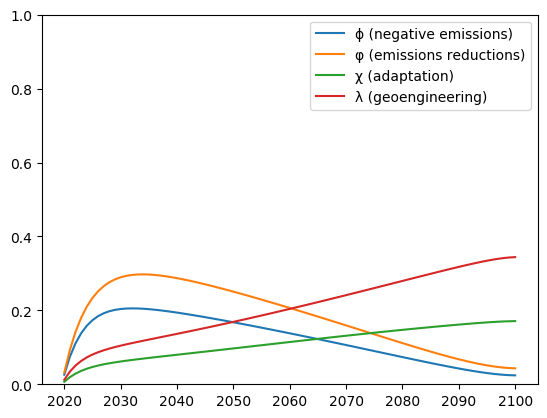

(0, 1)

In [82]:
plot(t, value.(ϕ), label="ϕ (negative emissions)")
plot(t, value.(φ), label="φ (emissions reductions)")
plot(t, value.(χ), label="χ (adaptation)")
plot(t, value.(λ), label="λ (geoengineering)")

legend()
ylim(0,1)